In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(120, return_sequences=True),
  tf.keras.layers.SimpleRNN(120),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 35ms/step - loss: 24.6216 - mae: 25.1197 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 23.5298 - mae: 24.0261 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 21.8421 - mae: 22.3388 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 19.8972 - mae: 20.3919 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 17.8894 - mae: 18.3835 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 15.9466 - mae: 16.4403 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 14.2017 - mae: 14.6897 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 12.9164 - mae: 13.4098 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 23ms/step - loss: 11.9120 - mae: 12.4022 - lr: 2.5

8/8 [==============================] - 0s 23ms/step - loss: 20.8507 - mae: 21.3486 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 24ms/step - loss: 22.0108 - mae: 22.5066 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 22ms/step - loss: 21.1904 - mae: 21.6886 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 22ms/step - loss: 23.8051 - mae: 24.3031 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 22ms/step - loss: 25.3485 - mae: 25.8462 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 22ms/step - loss: 27.6271 - mae: 28.1264 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 23ms/step - loss: 29.6434 - mae: 30.1420 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 23ms/step - loss: 32.0996 - mae: 32.5984 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 23ms/step - loss: 32.1450 - mae: 32.6435 - lr: 1.1220e

(1e-08, 0.0001, 0.0, 30.0)

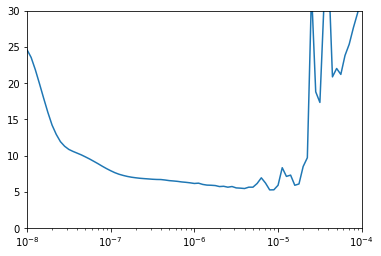

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 32ms/step - loss: 80.4489 - mae: 80.9486
Epoch 2/400
8/8 [==============================] - 0s 21ms/step - loss: 35.1623 - mae: 35.6595
Epoch 3/400
8/8 [==============================] - 0s 21ms/step - loss: 21.5787 - mae: 22.0740
Epoch 4/400
8/8 [==============================] - 0s 22ms/step - loss: 15.9963 - mae: 16.4912
Epoch 5/400
8/8 [==============================] - 0s 21ms/step - loss: 14.0088 - mae: 14.5026
Epoch 6/400
8/8 [==============================] - 0s 21ms/step - loss: 10.5099 - mae: 10.9995
Epoch 7/400
8/8 [==============================] - 0s 21ms/step - loss: 8.9607 - mae: 9.4478
Epoch 8/400
8/8 [==============================] - 0s 21ms/step - loss: 10.2102 - mae: 10.7007
Epoch 9/400
8/8 [==============================] - 0s 21ms/step - loss: 11.1282 - mae: 11.6162
Epoch 10/400
8/8 [==============================] - 0s 21ms/step - loss: 7.6731 - mae: 8.1582
Epoch 11/400
8/8 [==============================] - 0

8/8 [==============================] - 0s 22ms/step - loss: 4.8080 - mae: 5.2871
Epoch 89/400
8/8 [==============================] - 0s 21ms/step - loss: 4.7044 - mae: 5.1810
Epoch 90/400
8/8 [==============================] - 0s 22ms/step - loss: 4.7526 - mae: 5.2319
Epoch 91/400
8/8 [==============================] - 0s 21ms/step - loss: 4.6178 - mae: 5.0935
Epoch 92/400
8/8 [==============================] - 0s 21ms/step - loss: 4.5782 - mae: 5.0579
Epoch 93/400
8/8 [==============================] - 0s 21ms/step - loss: 5.2509 - mae: 5.7312
Epoch 94/400
8/8 [==============================] - 0s 22ms/step - loss: 5.6691 - mae: 6.1524
Epoch 95/400
8/8 [==============================] - 0s 21ms/step - loss: 4.9942 - mae: 5.4706
Epoch 96/400
8/8 [==============================] - 0s 23ms/step - loss: 5.5588 - mae: 6.0385
Epoch 97/400
8/8 [==============================] - 0s 22ms/step - loss: 5.1682 - mae: 5.6486
Epoch 98/400
8/8 [==============================] - 0s 22ms/step - loss: 

8/8 [==============================] - 0s 22ms/step - loss: 4.5690 - mae: 5.0472
Epoch 175/400
8/8 [==============================] - 0s 22ms/step - loss: 4.3735 - mae: 4.8479
Epoch 176/400
8/8 [==============================] - 0s 22ms/step - loss: 4.2035 - mae: 4.6742
Epoch 177/400
8/8 [==============================] - 0s 25ms/step - loss: 4.1934 - mae: 4.6683
Epoch 178/400
8/8 [==============================] - 0s 22ms/step - loss: 4.8845 - mae: 5.3648
Epoch 179/400
8/8 [==============================] - 0s 23ms/step - loss: 4.3993 - mae: 4.8767
Epoch 180/400
8/8 [==============================] - 0s 22ms/step - loss: 4.1668 - mae: 4.6398
Epoch 181/400
8/8 [==============================] - 0s 22ms/step - loss: 5.0650 - mae: 5.5456
Epoch 182/400
8/8 [==============================] - 0s 22ms/step - loss: 4.7801 - mae: 5.2557
Epoch 183/400
8/8 [==============================] - 0s 21ms/step - loss: 4.6749 - mae: 5.1528
Epoch 184/400
8/8 [==============================] - 0s 22ms/ste

8/8 [==============================] - 0s 21ms/step - loss: 4.4329 - mae: 4.9061
Epoch 261/400
8/8 [==============================] - 0s 21ms/step - loss: 4.4932 - mae: 4.9687
Epoch 262/400
8/8 [==============================] - 0s 21ms/step - loss: 4.3954 - mae: 4.8688
Epoch 263/400
8/8 [==============================] - 0s 20ms/step - loss: 4.4822 - mae: 4.9570
Epoch 264/400
8/8 [==============================] - 0s 21ms/step - loss: 4.1689 - mae: 4.6430
Epoch 265/400
8/8 [==============================] - 0s 22ms/step - loss: 4.4953 - mae: 4.9730
Epoch 266/400
8/8 [==============================] - 0s 22ms/step - loss: 4.2972 - mae: 4.7752
Epoch 267/400
8/8 [==============================] - 0s 23ms/step - loss: 4.0159 - mae: 4.4869
Epoch 268/400
8/8 [==============================] - 0s 22ms/step - loss: 4.4721 - mae: 4.9496
Epoch 269/400
8/8 [==============================] - 0s 22ms/step - loss: 4.2738 - mae: 4.7484
Epoch 270/400
8/8 [==============================] - 0s 23ms/ste

8/8 [==============================] - 0s 24ms/step - loss: 4.7633 - mae: 5.2408
Epoch 347/400
8/8 [==============================] - 0s 23ms/step - loss: 5.0095 - mae: 5.4864
Epoch 348/400
8/8 [==============================] - 0s 23ms/step - loss: 4.5168 - mae: 4.9939
Epoch 349/400
8/8 [==============================] - 0s 23ms/step - loss: 4.4270 - mae: 4.8988
Epoch 350/400
8/8 [==============================] - 0s 25ms/step - loss: 4.7030 - mae: 5.1794
Epoch 351/400
8/8 [==============================] - 0s 23ms/step - loss: 4.8360 - mae: 5.3125
Epoch 352/400
8/8 [==============================] - 0s 24ms/step - loss: 4.8972 - mae: 5.3729
Epoch 353/400
8/8 [==============================] - 0s 25ms/step - loss: 4.6568 - mae: 5.1288
Epoch 354/400
8/8 [==============================] - 0s 23ms/step - loss: 4.3125 - mae: 4.7887
Epoch 355/400
8/8 [==============================] - 0s 22ms/step - loss: 5.4023 - mae: 5.8850
Epoch 356/400
8/8 [==============================] - 0s 24ms/ste

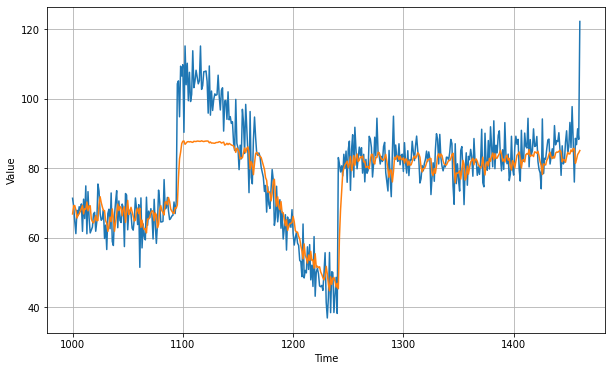

In [13]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.9374847

<Figure size 432x288 with 0 Axes>

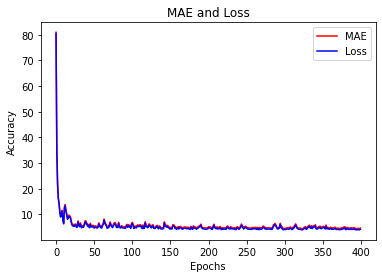

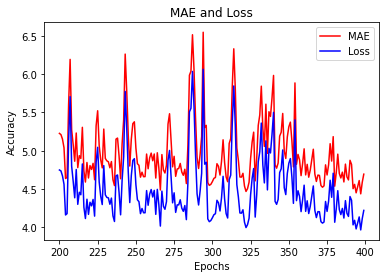

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()